In [3]:
#pip install networkx==2.2

In [1]:
import pandas as pd
import networkx as nx
import pquality
import numpy as np
print(nx.__version__)
import matplotlib.pyplot as plt
import nxmetis
import community
import sklearn
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import networkx.algorithms.community as nx_comm

2.2


In [2]:
df = pd.read_csv('C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/USA election Twitter collection/Polarized_dataset.csv')

In [3]:
#DELETE NaN Values
df['Screen_name'] = df['Screen_name'].replace('', np.nan)
df['Retweet'] = df['Retweet'].replace('', np.nan)
df = df[df['Retweet'].notna()]
df = df[df['Screen_name'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663685 entries, 0 to 663684
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Screen_name         663685 non-null  object 
 1   Retweet             663685 non-null  object 
 2   Name                663666 non-null  object 
 3   Text_clean          663685 non-null  object 
 4   Day                 663685 non-null  int64  
 5   Polarization Score  663685 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 35.4+ MB


In [4]:
#DELETE USERS THAT RETWEET OUR SELF
df.drop_duplicates(subset=['Screen_name', 'Retweet'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612775 entries, 0 to 663683
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Screen_name         612775 non-null  object 
 1   Retweet             612775 non-null  object 
 2   Name                612756 non-null  object 
 3   Text_clean          612775 non-null  object 
 4   Day                 612775 non-null  int64  
 5   Polarization Score  612775 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 32.7+ MB


ASSIGN POLARIZATION SCORE

In [5]:
#CALCULATE POLARIZATION SCORE MEAN
df['Polarization Score Screen_name'] = df.groupby(['Screen_name'])['Polarization Score'].transform('mean')
#RESCALE THE POLARIZATION SCORE IN ORDER TO BE USED BY METIS
scaler = MinMaxScaler(feature_range=(-5,+5))
df['Polarization Score Screen_name'] = scaler.fit_transform(df[['Polarization Score Screen_name']])

In [6]:
#Compute the Polarization score for the Retweetted users

In [7]:
values = df['Retweet'].to_list()
#obtaining the list of Retweetted peple with a text associated
df2 = df.loc[df['Screen_name'].isin(values)]
#obtain the single values from the above list
df2 = df2.drop_duplicates(subset='Screen_name', keep="last")
df2 = df2.rename(columns={'Polarization Score Screen_name':'Polarization Score Retweet'})
df2 = df2.drop(['Retweet','Name','Text_clean','Day','Polarization Score'],axis=1)
#obtain the final dataset
df = df.merge(df2, how = 'left', on = ['Screen_name'])
#fill NaN values with neutral value of the polarization score
df['Polarization Score Retweet'] = df['Polarization Score Retweet'].fillna(0)
df['Polarization Score Retweet'] = df.groupby(['Retweet'])['Polarization Score Retweet'].transform('mean')

In [8]:
#EVALUATE TH NUMBER OF CONNECTION BETWEEN TWO USERS
helper = df.value_counts(['Screen_name','Retweet']).to_frame('Tot connection user1,user2').reset_index()
helper['key'] = helper['Screen_name'] + helper['Retweet']
df['key'] = df['Screen_name'] + df['Retweet']
df = pd.merge(df, helper, how="left", on=['key','key'])
df = df.drop(['key','Screen_name_y','Retweet_y','Name'],axis=1)
df = df.rename(columns={'Screen_name_x':'Screen_name','Retweet_x':'Retweet'})
#df['Total connections Screen_name'] = df.groupby('Screen_name')['Screen_name'].transform('count')
#df['Total connections Retweet'] = df.groupby('Retweet')['Retweet'].transform('count')

In [9]:
df['Polarization Score Screen_name'] = df['Polarization Score Screen_name'].astype(int)
df['Polarization Score Retweet'] = df['Polarization Score Retweet'].astype(int) 

ASSIGN SENTIMENT ANALYSIS - LEXICON BASED

In [10]:
analyzer = SentimentIntensityAnalyzer()
df['Sentiment_Score_Vader_Screenname'] = [analyzer.polarity_scores(x)['compound'] for x in df['Text_clean']]
df['Sentiment_Score_Vader_Screenname'] = df.groupby(['Screen_name'])['Sentiment_Score_Vader_Screenname'].transform('mean')
df['Sentiment_Score_Vader_Screenname'] = scaler.fit_transform(df[['Sentiment_Score_Vader_Screenname']])
df['Sentiment_Score_Vader_Screenname'] = df['Sentiment_Score_Vader_Screenname'].astype(int) 
df['Sentiment_Score_Vader_Screenname'].describe()

count    612775.000000
mean          0.258116
std           1.402162
min          -5.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: Sentiment_Score_Vader_Screenname, dtype: float64

In [11]:
values = df['Retweet'].to_list()
#obtaining the list of Retweetted peple with a text associated
df2 = df.loc[df['Screen_name'].isin(values)]
df2 = df2.drop_duplicates(subset='Screen_name', keep="last")
df2 = df2.rename(columns={'Sentiment_Score_Vader_Screenname':'Sentiment_Score_Vader_Retweet'})
df2 = df2.drop(['Retweet','Text_clean','Day','Polarization Score','Polarization Score Screen_name','Polarization Score Retweet','Tot connection user1,user2'],axis=1)
#obtain the final dataset
df = df.merge(df2, how = 'left', on = ['Screen_name'])

In [12]:
df['Sentiment_Score_Vader_Retweet'] = df['Sentiment_Score_Vader_Retweet'].fillna(0)
df['Sentiment_Score_Vader_Retweet'] = df.groupby(['Retweet'])['Sentiment_Score_Vader_Retweet'].transform('mean')
df['Sentiment_Score_Vader_Retweet'] = df['Sentiment_Score_Vader_Retweet'].astype(int)

(-5.0, 5.0)

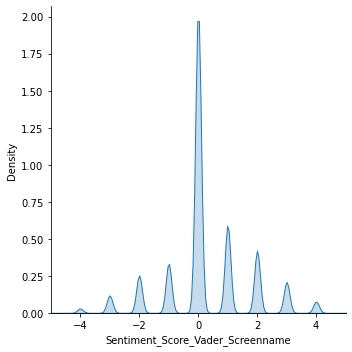

In [13]:
#DENSITY SENTIMENT
density = sns.displot(df, x="Sentiment_Score_Vader_Screenname",kind="kde", fill=True)
plt.xlim(-5,+5)

(-5.0, 5.0)

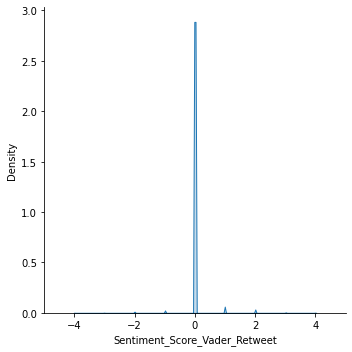

In [14]:
#DENSITY SENTIMENT
density = sns.displot(df, x="Sentiment_Score_Vader_Retweet",kind="kde", fill=True)
plt.xlim(-5,+5)

(-5.0, 5.0)

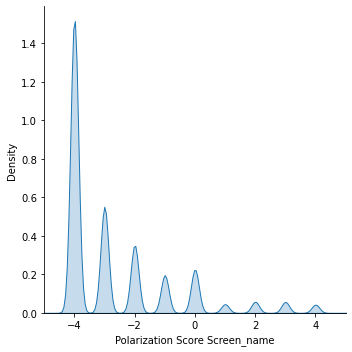

In [15]:
#DENSITY POLARIZATION
density = sns.displot(df, x="Polarization Score Screen_name",kind="kde", fill=True)
plt.xlim(-5,+5)

(-5.0, 5.0)

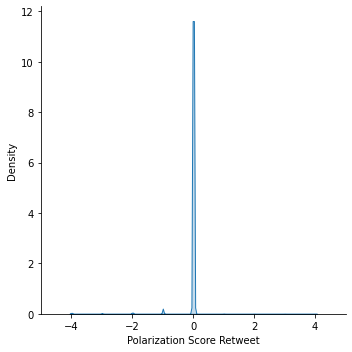

In [16]:
#DENSITY POLARIZATION
density = sns.displot(df, x="Polarization Score Retweet",kind="kde", fill=True)
plt.xlim(-5,+5)

EVALUATE HYBRID MEASURE

In [17]:
df['Polarization distance'] = 10 - abs(df['Polarization Score Screen_name']-df['Polarization Score Retweet'])
df['Sentiment distance'] = 10 - abs(df['Sentiment_Score_Vader_Screenname']-df['Sentiment_Score_Vader_Retweet'])
df['Polarization hybrid measure'] = df['Tot connection user1,user2']*(10 - abs(df['Polarization Score Screen_name']-df['Polarization Score Retweet']))
df['Sentiment hybrid measure'] = df['Tot connection user1,user2']*(10 - abs(df['Sentiment_Score_Vader_Screenname']-df['Sentiment_Score_Vader_Retweet']))

(0.0, 15.0)

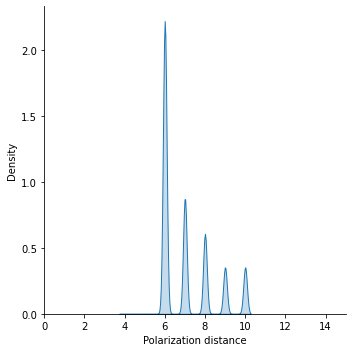

In [18]:
density = sns.displot(df, x='Polarization distance',kind="kde", fill=True)
plt.xlim(0,+15)

(0.0, 15.0)

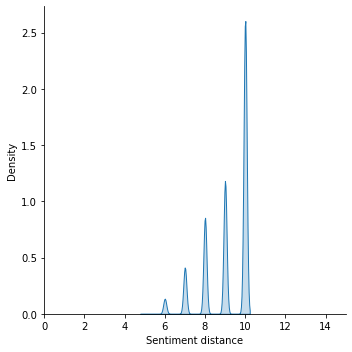

In [19]:
density = sns.displot(df, x='Sentiment distance',kind="kde", fill=True)
plt.xlim(0,15)

In [20]:
df['Key'] = df['Screen_name'] + df['Retweet']
df = df.drop_duplicates(subset=["Key"], keep='last')
df = df.drop(['Key'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 612775 entries, 0 to 612774
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Screen_name                       612775 non-null  object 
 1   Retweet                           612775 non-null  object 
 2   Text_clean                        612775 non-null  object 
 3   Day                               612775 non-null  int64  
 4   Polarization Score                612775 non-null  float64
 5   Polarization Score Screen_name    612775 non-null  int32  
 6   Polarization Score Retweet        612775 non-null  int32  
 7   Tot connection user1,user2        612775 non-null  int64  
 8   Sentiment_Score_Vader_Screenname  612775 non-null  int32  
 9   Sentiment_Score_Vader_Retweet     612775 non-null  int32  
 10  Polarization distance             612775 non-null  int32  
 11  Sentiment distance                612775 non-null  i

COMMUNITY DETECTION

DAY 2

In [21]:
df_2Nov = df.loc[df['Day']==2]
#df_2Nov = df_2Nov[['Screen_name','Retweet','Text_clean', 'Sentiment_Score_Vader_Screenname', 'Polarization Score Screen_name' ,'Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_2Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [22]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_2 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_2 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_2 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_2 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_2 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                         min         max         avg        std
Index                                                          
Internal Density      0.0001      0.0002      0.0002     0.0000
Edges inside      10179.0000  14777.0000  12478.0000  2299.0000
Average Degree        1.7049      2.4738      2.0893     0.3844
FOMD                  0.1238      0.2584      0.1911     0.0673
TPR                   0.0022      0.0160      0.0091     0.0069
Expansion             0.0029      0.0029      0.0029     0.0000
Cut Ratio             0.0000      0.0000      0.0000     0.0000
Conductance           0.0012      0.0017      0.0014     0.0003
Normalized Cut        0.0029      0.0029      0.0029     0.0000
Maximum-ODF           3.0000      7.0000      5.0000     2.0000
Average-ODF           0.0029      0.0029      0.0029     0.0000
Flake-ODF             0.0000      0.0000      0.0000     0.0000
                          value
Index                          
Modul

In [23]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_2[0])
df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")
df_2Nov_community0 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='0']
df_2Nov_community1 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='1']
Gcommunity0_2Nov = nx.from_pandas_edgelist(df_2Nov_community0, 'Screen_name', 'Retweet')
mod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov))
print("Density della community 0: ", nx.density(Gcommunity0_2Nov))

Gcommunity1_2Nov = nx.from_pandas_edgelist(df_2Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov))
print("Density della community 1: ", nx.density(Gcommunity1_2Nov))

nowmod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)
nowmod1_2nov = community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)
nodes_comm0_noweight2nov = Gcommunity0_2Nov.number_of_nodes()
nodes_comm1_noweight2nov = Gcommunity1_2Nov.number_of_nodes()
print(nodes_comm0_noweight2nov)
print(nodes_comm1_noweight2nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3314108553.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3314108553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  0.7892406667008564
Density della community 0:  0.00020702459017586842
Modularity community 1:  0.950211865454915
Density della community 1:  0.00014276521230291076
11953
11956


In [24]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_2[0])
df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")
df_2Nov_community0 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='0']
df_2Nov_community1 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='1']
Gcommunity0_2Nov = nx.from_pandas_edgelist(df_2Nov_community0, 'Screen_name', 'Retweet')
mod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100)
Gcommunity1_2Nov = nx.from_pandas_edgelist(df_2Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)*100)
sentsimmod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100
sentsimmod1_2nov = community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)*100

nodes_comm0_sentsimmod0_2nov = Gcommunity0_2Nov.number_of_nodes()
nodes_comm1_sentsimmod1_2nov = Gcommunity1_2Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_2nov)
print(nodes_comm1_sentsimmod1_2nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/538496119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/538496119.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  95.07763836406234
Modularity community 1:  78.94897056409299
11972
11937


In [25]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_2[0])
df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")
df_2Nov_community0 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='0']
df_2Nov_community1 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='1']
Gcommunity0_2Nov = nx.from_pandas_edgelist(df_2Nov_community0, 'Screen_name', 'Retweet')
mod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100)
Gcommunity1_2Nov = nx.from_pandas_edgelist(df_2Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)*100)
polsimmod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100
polsimmod1_2nov = community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)*100

nodes_comm0_polsimmod0_2nov = Gcommunity0_2Nov.number_of_nodes()
nodes_comm1_polsimmod1_2nov = Gcommunity1_2Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_2nov)
print(nodes_comm1_polsimmod1_2nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1541213851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1541213851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  78.99073321652595
Modularity community 1:  95.04413812922408
11954
11955


In [28]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT BOOST
community0 = list(sentimenthybrid_parts_communities_2[0])
df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")
df_2Nov_community0 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='0']
df_2Nov_community1 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='1']
Gcommunity0_2Nov = nx.from_pandas_edgelist(df_2Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100)
Gcommunity1_2Nov = nx.from_pandas_edgelist(df_2Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_2Nov, random_state=1),Gcommunity1_2Nov)*100)
sentmod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100
sentmod1_2nov = community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)*100

nodes_comm0_sent2nov = Gcommunity0_2Nov.number_of_nodes()
nodes_comm1_sent2nov = Gcommunity1_2Nov.number_of_nodes()
print(nodes_comm0_sent2nov)
print(nodes_comm1_sent2nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_13640/2501463828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_13640/2501463828.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  95.18693809520136
Modularity community 1:  79.87551789164726
11591
11561


In [26]:
df_2Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day2_sent.csv", index=False)

In [27]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION BOOST
community0 = list(polarizationhybrid_parts_communities_2[0])
df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")
df_2Nov_community0 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='0']
df_2Nov_community1 = df_2Nov.loc[df_2Nov['Community_Screen_name']=='1']
Gcommunity0_2Nov = nx.from_pandas_edgelist(df_2Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100)
Gcommunity1_2Nov = nx.from_pandas_edgelist(df_2Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_2Nov, random_state=1),Gcommunity1_2Nov)*100)
polmod0_2nov = community.modularity(community.best_partition(Gcommunity0_2Nov, random_state=1),Gcommunity0_2Nov)*100
polmod1_2nov = community.modularity(community.best_partition(Gcommunity1_2Nov,random_state=1),Gcommunity1_2Nov)*100

nodes_comm0_pol2nov = Gcommunity0_2Nov.number_of_nodes()
nodes_comm1_pol2nov = Gcommunity1_2Nov.number_of_nodes()
print(nodes_comm0_pol2nov)
print(nodes_comm1_pol2nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/7111892.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Screen_name"] = np.where(df_2Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/7111892.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2Nov["Community_Retweet"] = np.where(df_2Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  78.99073321652595
Modularity community 1:  95.04413812922408
11954
11955


DAY 3

In [28]:
df_3Nov = df.loc[df['Day']==3]
#df_3Nov = df_3Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_3Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [29]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_3 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_3 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_3 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_3 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_3 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                         min         max         avg        std
Index                                                          
Internal Density      0.0001      0.0001      0.0001     0.0000
Edges inside      28695.0000  43479.0000  36087.0000  7392.0000
Average Degree        1.8084      2.7443      2.2763     0.4679
FOMD                  0.1569      0.2961      0.2265     0.0696
TPR                   0.0051      0.0385      0.0218     0.0167
Expansion             0.0053      0.0053      0.0053     0.0000
Cut Ratio             0.0000      0.0000      0.0000     0.0000
Conductance           0.0019      0.0029      0.0024     0.0005
Normalized Cut        0.0049      0.0049      0.0049     0.0000
Maximum-ODF           6.0000     10.0000      8.0000     2.0000
Average-ODF           0.0053      0.0053      0.0053     0.0000
Flake-ODF             0.0000      0.0000      0.0000     0.0000
                          value
Index                          
Modul

In [30]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_3[0])
df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")
df_3Nov_community0 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='0']
df_3Nov_community1 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='1']
Gcommunity0_3Nov = nx.from_pandas_edgelist(df_3Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100)
Gcommunity1_3Nov = nx.from_pandas_edgelist(df_3Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_3Nov, random_state=1),Gcommunity1_3Nov)*100)
nowmod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
nowmod1_3nov = community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100

nodes_comm0_noweight3nov = Gcommunity0_3Nov.number_of_nodes()
nodes_comm1_noweight3nov = Gcommunity1_3Nov.number_of_nodes()
print(nodes_comm0_noweight3nov)
print(nodes_comm1_noweight3nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2379415859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2379415859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  93.64193528043586
Modularity community 1:  71.95404121079278
31780
31757


In [31]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_3[0])
df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")
df_3Nov_community0 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='0']
df_3Nov_community1 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='1']
Gcommunity0_3Nov = nx.from_pandas_edgelist(df_3Nov_community0, 'Screen_name', 'Retweet')
mod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100)
Gcommunity1_3Nov = nx.from_pandas_edgelist(df_3Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100)
sentsimmod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
sentsimmod1_3nov = community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100

nodes_comm0_sentsimmod0_3nov = Gcommunity0_3Nov.number_of_nodes()
nodes_comm1_sentsimmod1_3nov = Gcommunity1_3Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_3nov)
print(nodes_comm1_sentsimmod1_3nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3884517560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3884517560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  71.90864149984198
Modularity community 1:  93.65344730811651
31683
31852


In [32]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_3[0])
df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")
df_3Nov_community0 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='0']
df_3Nov_community1 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='1']
Gcommunity0_3Nov = nx.from_pandas_edgelist(df_3Nov_community0, 'Screen_name', 'Retweet')
mod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100)
Gcommunity1_3Nov = nx.from_pandas_edgelist(df_3Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100)
polsimmod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
polsimmod1_3nov = community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100

nodes_comm0_polsimmod0_3nov = Gcommunity0_3Nov.number_of_nodes()
nodes_comm1_polsimmod1_3nov = Gcommunity1_3Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_3nov)
print(nodes_comm1_polsimmod1_3nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3538145484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3538145484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  71.96405900142094
Modularity community 1:  93.65266374231813
31708
31828


In [33]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_3[0])
df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")
df_3Nov_community0 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='0']
df_3Nov_community1 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='1']
Gcommunity0_3Nov = nx.from_pandas_edgelist(df_3Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100)
Gcommunity1_3Nov = nx.from_pandas_edgelist(df_3Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_3Nov, random_state=1),Gcommunity1_3Nov)*100)
sentmod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
sentmod1_3nov = community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100

nodes_comm0_sent3nov = Gcommunity0_3Nov.number_of_nodes()
nodes_comm1_sent3nov = Gcommunity1_3Nov.number_of_nodes()
print(nodes_comm0_sent3nov)
print(nodes_comm1_sent3nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2090553733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2090553733.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  71.90864149984198
Modularity community 1:  93.65344730811651
31683
31852


In [34]:
df_3Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day3_sent.csv", index=False)

In [35]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_3[0])
df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")
df_3Nov_community0 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='0']
df_3Nov_community1 = df_3Nov.loc[df_3Nov['Community_Screen_name']=='1']
Gcommunity0_3Nov = nx.from_pandas_edgelist(df_3Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100)
Gcommunity1_3Nov = nx.from_pandas_edgelist(df_3Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_3Nov, random_state=1),Gcommunity1_3Nov)*100)
polmod0_3nov = community.modularity(community.best_partition(Gcommunity0_3Nov, random_state=1),Gcommunity0_3Nov)*100
polmod1_3nov = community.modularity(community.best_partition(Gcommunity1_3Nov,random_state=1),Gcommunity1_3Nov)*100

nodes_comm0_pol3nov = Gcommunity0_3Nov.number_of_nodes()
nodes_comm1_pol3nov = Gcommunity1_3Nov.number_of_nodes()
print(nodes_comm0_pol3nov)
print(nodes_comm1_pol3nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2392389481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Screen_name"] = np.where(df_3Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2392389481.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3Nov["Community_Retweet"] = np.where(df_3Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  71.96405900142094
Modularity community 1:  93.65266374231813
31708
31828


DAY 4

In [36]:
df_4Nov = df.loc[df['Day']==4]
#df_4Nov = df_4Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_4Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [37]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_4 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_4 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_4 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_4 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_4 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                         min         max         avg       std
Index                                                         
Internal Density      0.0001      0.0001      0.0001    0.0000
Edges inside      33519.0000  35137.0000  34328.0000  809.0000
Average Degree        2.0283      2.1264      2.0773    0.0490
FOMD                  0.1246      0.1886      0.1566    0.0320
TPR                   0.0037      0.0064      0.0050    0.0013
Expansion             0.0057      0.0057      0.0057    0.0000
Cut Ratio             0.0000      0.0000      0.0000    0.0000
Conductance           0.0027      0.0028      0.0027    0.0001
Normalized Cut        0.0055      0.0055      0.0055    0.0000
Maximum-ODF          16.0000     18.0000     17.0000    1.0000
Average-ODF           0.0057      0.0057      0.0057    0.0000
Flake-ODF             0.0000      0.0000      0.0000    0.0000
                         value
Index                         
Modularity (no overla

In [38]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_4[0])
df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")
df_4Nov_community0 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='0']
df_4Nov_community1 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='1']
Gcommunity0_4Nov = nx.from_pandas_edgelist(df_4Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100)
Gcommunity1_4Nov = nx.from_pandas_edgelist(df_4Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_4Nov, random_state=1),Gcommunity1_4Nov)*100)
nowmod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
nowmod1_4nov = community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100

nodes_comm0_noweight4nov = Gcommunity0_4Nov.number_of_nodes()
nodes_comm1_noweight4nov = Gcommunity1_4Nov.number_of_nodes()
print(nodes_comm0_noweight4nov)
print(nodes_comm1_noweight4nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/716480008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/716480008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  80.99378432746417
Modularity community 1:  93.07160986761916
33090
33103


In [39]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_4[0])
df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")
df_4Nov_community0 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='0']
df_4Nov_community1 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='1']
Gcommunity0_4Nov = nx.from_pandas_edgelist(df_4Nov_community0, 'Screen_name', 'Retweet')
mod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100)
Gcommunity1_4Nov = nx.from_pandas_edgelist(df_4Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100)
sentsimmod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
sentsimmod1_4nov = community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100

nodes_comm0_sentsimmod0_4nov = Gcommunity0_4Nov.number_of_nodes()
nodes_comm1_sentsimmod1_4nov = Gcommunity1_4Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_4nov)
print(nodes_comm1_sentsimmod1_4nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2616481168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2616481168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  93.09845814583997
Modularity community 1:  80.99754029591111
33090
33100


In [40]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_4[0])
df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")
df_4Nov_community0 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='0']
df_4Nov_community1 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='1']
Gcommunity0_4Nov = nx.from_pandas_edgelist(df_4Nov_community0, 'Screen_name', 'Retweet')
mod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100)
Gcommunity1_4Nov = nx.from_pandas_edgelist(df_4Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100)
polsimmod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
polsimmod1_4nov = community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100

nodes_comm0_polsimmod0_4nov = Gcommunity0_4Nov.number_of_nodes()
nodes_comm1_polsimmod1_4nov = Gcommunity1_4Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_4nov)
print(nodes_comm1_polsimmod1_4nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/660250820.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/660250820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  80.98050087165383
Modularity community 1:  93.09217204702114
33113
33078


In [41]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_4[0])
df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")
df_4Nov_community0 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='0']
df_4Nov_community1 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='1']
Gcommunity0_4Nov = nx.from_pandas_edgelist(df_4Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100)
Gcommunity1_4Nov = nx.from_pandas_edgelist(df_4Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_4Nov, random_state=1),Gcommunity1_4Nov)*100)
sentmod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
sentmod1_4nov = community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100

nodes_comm0_sent4nov = Gcommunity0_4Nov.number_of_nodes()
nodes_comm1_sent4nov = Gcommunity1_4Nov.number_of_nodes()
print(nodes_comm0_sent4nov)
print(nodes_comm1_sent4nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/4176872589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/4176872589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  93.09845814583997
Modularity community 1:  80.99754029591111
33090
33100


In [42]:
df_4Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day4_sent.csv", index=False)

In [43]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_4[0])
df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")
df_4Nov_community0 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='0']
df_4Nov_community1 = df_4Nov.loc[df_4Nov['Community_Screen_name']=='1']
Gcommunity0_4Nov = nx.from_pandas_edgelist(df_4Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100)
Gcommunity1_4Nov = nx.from_pandas_edgelist(df_4Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_4Nov, random_state=1),Gcommunity1_4Nov)*100)
polmod0_4nov = community.modularity(community.best_partition(Gcommunity0_4Nov, random_state=1),Gcommunity0_4Nov)*100
polmod1_4nov = community.modularity(community.best_partition(Gcommunity1_4Nov,random_state=1),Gcommunity1_4Nov)*100

nodes_comm0_pol4nov = Gcommunity0_4Nov.number_of_nodes()
nodes_comm1_pol4nov = Gcommunity1_4Nov.number_of_nodes()
print(nodes_comm0_pol4nov)
print(nodes_comm1_pol4nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3939444149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Screen_name"] = np.where(df_4Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3939444149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4Nov["Community_Retweet"] = np.where(df_4Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  80.98050087165383
Modularity community 1:  93.09217204702114
33113
33078


DAY 5

In [44]:
df_5Nov = df.loc[df['Day']==5]
#df_5Nov = df_5Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_5Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [45]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_5 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_5 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_5 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_5 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_5 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                         min         max         avg        std
Index                                                          
Internal Density      0.0001      0.0001      0.0001     0.0000
Edges inside      34296.0000  36326.0000  35311.0000  1015.0000
Average Degree        2.0642      2.1832      2.1237     0.0595
FOMD                  0.1311      0.1962      0.1637     0.0326
TPR                   0.0066      0.0072      0.0069     0.0003
Expansion             0.0059      0.0059      0.0059     0.0000
Cut Ratio             0.0000      0.0000      0.0000     0.0000
Conductance           0.0027      0.0029      0.0028     0.0001
Normalized Cut        0.0056      0.0056      0.0056     0.0000
Maximum-ODF          17.0000     17.0000     17.0000     0.0000
Average-ODF           0.0059      0.0059      0.0059     0.0000
Flake-ODF             0.0000      0.0000      0.0000     0.0000
                          value
Index                          
Modul

In [46]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_5[0])
df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")
df_5Nov_community0 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='0']
df_5Nov_community1 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='1']
Gcommunity0_5Nov = nx.from_pandas_edgelist(df_5Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100)
Gcommunity1_5Nov = nx.from_pandas_edgelist(df_5Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_5Nov, random_state=1),Gcommunity1_5Nov)*100)
nowmod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
nowmod1_5nov = community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100

nodes_comm0_noweight5nov = Gcommunity0_5Nov.number_of_nodes()
nodes_comm1_noweight5nov = Gcommunity1_5Nov.number_of_nodes()
print(nodes_comm0_noweight5nov)
print(nodes_comm1_noweight5nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/794740537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/794740537.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  90.5081446096162
Modularity community 1:  82.9887617181697
33313
33294


In [47]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_5[0])
df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")
df_5Nov_community0 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='0']
df_5Nov_community1 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='1']
Gcommunity0_5Nov = nx.from_pandas_edgelist(df_5Nov_community0, 'Screen_name', 'Retweet')
mod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100)
Gcommunity1_5Nov = nx.from_pandas_edgelist(df_5Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100)
sentsimmod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
sentsimmod1_5nov = community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100

nodes_comm0_sentsimmod0_5nov = Gcommunity0_5Nov.number_of_nodes()
nodes_comm1_sentsimmod1_5nov = Gcommunity1_5Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_5nov)
print(nodes_comm1_sentsimmod1_5nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3912575086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3912575086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  83.19843452680192
Modularity community 1:  90.43193152741996
33398
33235


In [48]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_5[0])
df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")
df_5Nov_community0 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='0']
df_5Nov_community1 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='1']
Gcommunity0_5Nov = nx.from_pandas_edgelist(df_5Nov_community0, 'Screen_name', 'Retweet')
mod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100)
Gcommunity1_5Nov = nx.from_pandas_edgelist(df_5Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100)
polsimmod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
polsimmod1_5nov = community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100

nodes_comm0_polsimmod0_5nov = Gcommunity0_5Nov.number_of_nodes()
nodes_comm1_polsimmod1_5nov = Gcommunity1_5Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_5nov)
print(nodes_comm1_polsimmod1_5nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/823627770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/823627770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  90.46601245333305
Modularity community 1:  83.04664374445099
33306
33304


In [49]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_5[0])
df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")
df_5Nov_community0 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='0']
df_5Nov_community1 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='1']
Gcommunity0_5Nov = nx.from_pandas_edgelist(df_5Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100)
Gcommunity1_5Nov = nx.from_pandas_edgelist(df_5Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_5Nov, random_state=1),Gcommunity1_5Nov)*100)
sentmod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
sentmod1_5nov = community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100

nodes_comm0_sent5nov = Gcommunity0_5Nov.number_of_nodes()
nodes_comm1_sent5nov = Gcommunity1_5Nov.number_of_nodes()
print(nodes_comm0_sent5nov)
print(nodes_comm1_sent5nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/518930120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/518930120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  83.19843452680192
Modularity community 1:  90.43193152741996
33398
33235


In [50]:
df_5Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day5_sent.csv", index=False)

In [51]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_5[0])
df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")
df_5Nov_community0 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='0']
df_5Nov_community1 = df_5Nov.loc[df_5Nov['Community_Screen_name']=='1']
Gcommunity0_5Nov = nx.from_pandas_edgelist(df_5Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100)
Gcommunity1_5Nov = nx.from_pandas_edgelist(df_5Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_5Nov, random_state=1),Gcommunity1_5Nov)*100)
polmod0_5nov = community.modularity(community.best_partition(Gcommunity0_5Nov, random_state=1),Gcommunity0_5Nov)*100
polmod1_5nov = community.modularity(community.best_partition(Gcommunity1_5Nov,random_state=1),Gcommunity1_5Nov)*100

nodes_comm0_pol5nov = Gcommunity0_5Nov.number_of_nodes()
nodes_comm1_pol5nov = Gcommunity1_5Nov.number_of_nodes()
print(nodes_comm0_pol5nov)
print(nodes_comm1_pol5nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3048711170.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Screen_name"] = np.where(df_5Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3048711170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5Nov["Community_Retweet"] = np.where(df_5Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  90.46601245333305
Modularity community 1:  83.04664374445099
33306
33304


DAY 6

In [52]:
df_6Nov = df.loc[df['Day']==6]
#df_6Nov = df_6Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_6Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [53]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_6 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_6 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_6 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_6 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_6 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                         min         max         avg        std
Index                                                          
Internal Density      0.0001      0.0001      0.0001     0.0000
Edges inside      31203.0000  35876.0000  33539.5000  2336.5000
Average Degree        1.9569      2.2500      2.1034     0.1465
FOMD                  0.1178      0.2095      0.1637     0.0459
TPR                   0.0037      0.0128      0.0083     0.0045
Expansion             0.0055      0.0055      0.0055     0.0000
Cut Ratio             0.0000      0.0000      0.0000     0.0000
Conductance           0.0024      0.0028      0.0026     0.0002
Normalized Cut        0.0052      0.0052      0.0052     0.0000
Maximum-ODF           9.0000     12.0000     10.5000     1.5000
Average-ODF           0.0055      0.0055      0.0055     0.0000
Flake-ODF             0.0000      0.0000      0.0000     0.0000
                         value
Index                         
Modular

In [54]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_6[0])
df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")
df_6Nov_community0 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='0']
df_6Nov_community1 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='1']
Gcommunity0_6Nov = nx.from_pandas_edgelist(df_6Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100)
Gcommunity1_6Nov = nx.from_pandas_edgelist(df_6Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_6Nov, random_state=1),Gcommunity1_6Nov)*100)
nowmod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
nowmod1_6nov = community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100

nodes_comm0_noweight6nov = Gcommunity0_6Nov.number_of_nodes()
nodes_comm1_noweight6nov = Gcommunity1_6Nov.number_of_nodes()
print(nodes_comm0_noweight6nov)
print(nodes_comm1_noweight6nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1343042377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1343042377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  93.9044159508067
Modularity community 1:  78.69334787872585
31936
31934


In [55]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY

community0 = list(sentiment_parts_communities_6[0])
df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")
df_6Nov_community0 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='0']
df_6Nov_community1 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='1']
Gcommunity0_6Nov = nx.from_pandas_edgelist(df_6Nov_community0, 'Screen_name', 'Retweet')
mod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100)
Gcommunity1_6Nov = nx.from_pandas_edgelist(df_6Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100)
sentsimmod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
sentsimmod1_6nov = community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100

nodes_comm0_sentsimmod0_6nov = Gcommunity0_6Nov.number_of_nodes()
nodes_comm1_sentsimmod1_6nov = Gcommunity1_6Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_6nov)
print(nodes_comm1_sentsimmod1_6nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1625278561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1625278561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  78.68985600425901
Modularity community 1:  93.88955045172395
31836
32031


In [56]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_6[0])
df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")
df_6Nov_community0 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='0']
df_6Nov_community1 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='1']
Gcommunity0_6Nov = nx.from_pandas_edgelist(df_6Nov_community0, 'Screen_name', 'Retweet')
mod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100)
Gcommunity1_6Nov = nx.from_pandas_edgelist(df_6Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100)
polsimmod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
polsimmod1_6nov = community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100

nodes_comm0_polsimmod0_6nov = Gcommunity0_6Nov.number_of_nodes()
nodes_comm1_polsimmod1_6nov = Gcommunity1_6Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_6nov)
print(nodes_comm1_polsimmod1_6nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3789387022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3789387022.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  78.6734543371518
Modularity community 1:  93.90928023235092
31817
32050


In [57]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_6[0])
df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")
df_6Nov_community0 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='0']
df_6Nov_community1 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='1']
Gcommunity0_6Nov = nx.from_pandas_edgelist(df_6Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100)
Gcommunity1_6Nov = nx.from_pandas_edgelist(df_6Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_6Nov, random_state=1),Gcommunity1_6Nov)*100)
sentmod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
sentmod1_6nov = community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100

nodes_comm0_sent6nov = Gcommunity0_6Nov.number_of_nodes()
nodes_comm1_sent6nov = Gcommunity1_6Nov.number_of_nodes()
print(nodes_comm0_sent6nov)
print(nodes_comm1_sent6nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3531362266.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3531362266.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  78.68985600425901
Modularity community 1:  93.88955045172395
31836
32031


In [58]:
df_6Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day6_sent.csv", index=False)

In [59]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_6[0])
df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")
df_6Nov_community0 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='0']
df_6Nov_community1 = df_6Nov.loc[df_6Nov['Community_Screen_name']=='1']
Gcommunity0_6Nov = nx.from_pandas_edgelist(df_6Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100)
Gcommunity1_6Nov = nx.from_pandas_edgelist(df_6Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_6Nov, random_state=1),Gcommunity1_6Nov)*100)
polmod0_6nov = community.modularity(community.best_partition(Gcommunity0_6Nov, random_state=1),Gcommunity0_6Nov)*100
polmod1_6nov = community.modularity(community.best_partition(Gcommunity1_6Nov,random_state=1),Gcommunity1_6Nov)*100

nodes_comm0_pol6nov = Gcommunity0_6Nov.number_of_nodes()
nodes_comm1_pol6nov = Gcommunity1_6Nov.number_of_nodes()
print(nodes_comm0_pol6nov)
print(nodes_comm1_pol6nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2357207707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Screen_name"] = np.where(df_6Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2357207707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_6Nov["Community_Retweet"] = np.where(df_6Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  78.6734543371518
Modularity community 1:  93.90928023235092
31817
32050


DAY 7


In [60]:
df_7Nov = df.loc[df['Day']==7]
#df_7Nov = df_7Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_7Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [61]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_7 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_7 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_7 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_7 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_7 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                          min          max          avg        std
Index                                                             
Internal Density       0.0000       0.0000       0.0000     0.0000
Edges inside      118679.0000  125801.0000  122240.0000  3561.0000
Average Degree         2.2035       2.3324       2.2680     0.0644
FOMD                   0.1753       0.1898       0.1826     0.0072
TPR                    0.0075       0.0128       0.0102     0.0027
Expansion              0.0230       0.0230       0.0230     0.0000
Cut Ratio              0.0000       0.0000       0.0000     0.0000
Conductance            0.0098       0.0103       0.0100     0.0003
Normalized Cut         0.0199       0.0199       0.0199     0.0000
Maximum-ODF          139.0000     146.0000     142.5000     3.5000
Average-ODF            0.0230       0.0230       0.0230     0.0000
Flake-ODF              0.0000       0.0000       0.0000     0.0000
                          v

In [62]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_7[0])
df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")
df_7Nov_community0 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='0']
df_7Nov_community1 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='1']
Gcommunity0_7Nov = nx.from_pandas_edgelist(df_7Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100)
Gcommunity1_7Nov = nx.from_pandas_edgelist(df_7Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_7Nov, random_state=1),Gcommunity1_7Nov)*100)
nowmod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
nowmod1_7nov = community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100

nodes_comm0_noweight7nov = Gcommunity0_7Nov.number_of_nodes()
nodes_comm1_noweight7nov = Gcommunity1_7Nov.number_of_nodes()
print(nodes_comm0_noweight7nov)
print(nodes_comm1_noweight7nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/4161551978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/4161551978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  85.93541826607968
Modularity community 1:  81.07634599661493
108051
108157


In [63]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_7[0])
df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")
df_7Nov_community0 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='0']
df_7Nov_community1 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='1']
Gcommunity0_7Nov = nx.from_pandas_edgelist(df_7Nov_community0, 'Screen_name', 'Retweet')
mod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100)
Gcommunity1_7Nov = nx.from_pandas_edgelist(df_7Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100)
sentsimmod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
sentsimmod1_7nov = community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100

nodes_comm0_sentsimmod0_7nov = Gcommunity0_7Nov.number_of_nodes()
nodes_comm1_sentsimmod1_7nov = Gcommunity1_7Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_7nov)
print(nodes_comm1_sentsimmod1_7nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/616175975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/616175975.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  86.06997821900752
Modularity community 1:  80.77285694841419
107795
108349


In [64]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_7[0])
df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")
df_7Nov_community0 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='0']
df_7Nov_community1 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='1']
Gcommunity0_7Nov = nx.from_pandas_edgelist(df_7Nov_community0, 'Screen_name', 'Retweet')
mod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100)
Gcommunity1_7Nov = nx.from_pandas_edgelist(df_7Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100)
polsimmod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
polsimmod1_7nov = community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100

nodes_comm0_polsimmod0_7nov = Gcommunity0_7Nov.number_of_nodes()
nodes_comm1_polsimmod1_7nov = Gcommunity1_7Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_7nov)
print(nodes_comm1_polsimmod1_7nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/819305791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/819305791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  85.81840983305469
Modularity community 1:  81.17284602802413
108023
108167


In [65]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_7[0])
df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")
df_7Nov_community0 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='0']
df_7Nov_community1 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='1']
Gcommunity0_7Nov = nx.from_pandas_edgelist(df_7Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100)
Gcommunity1_7Nov = nx.from_pandas_edgelist(df_7Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_7Nov, random_state=1),Gcommunity1_7Nov)*100)
sentmod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
sentmod1_7nov = community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100

nodes_comm0_sent7nov = Gcommunity0_7Nov.number_of_nodes()
nodes_comm1_sent7nov = Gcommunity1_7Nov.number_of_nodes()
print(nodes_comm0_sent7nov)
print(nodes_comm1_sent7nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1571960474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1571960474.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  86.06997821900752
Modularity community 1:  80.77285694841419
107795
108349


In [66]:
df_7Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day7_sent.csv", index=False)

In [67]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_7[0])
df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")
df_7Nov_community0 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='0']
df_7Nov_community1 = df_7Nov.loc[df_7Nov['Community_Screen_name']=='1']
Gcommunity0_7Nov = nx.from_pandas_edgelist(df_7Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100)
Gcommunity1_7Nov = nx.from_pandas_edgelist(df_7Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_7Nov, random_state=1),Gcommunity1_7Nov)*100)
polmod0_7nov = community.modularity(community.best_partition(Gcommunity0_7Nov, random_state=1),Gcommunity0_7Nov)*100
polmod1_7nov = community.modularity(community.best_partition(Gcommunity1_7Nov,random_state=1),Gcommunity1_7Nov)*100

nodes_comm0_pol7nov = Gcommunity0_7Nov.number_of_nodes()
nodes_comm1_pol7nov = Gcommunity1_7Nov.number_of_nodes()
print(nodes_comm0_pol7nov)
print(nodes_comm1_pol7nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/232372396.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Screen_name"] = np.where(df_7Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/232372396.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_7Nov["Community_Retweet"] = np.where(df_7Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  85.81840983305469
Modularity community 1:  81.17284602802413
108023
108167


DAY 8

In [68]:
df_8Nov = df.loc[df['Day']==8]
#df_8Nov = df_8Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_8Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [69]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_8 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_8 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_8 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(4))
print(scores_senthib['Modularity'].round(4))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_8 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_8 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                         min         max         avg        std
Index                                                          
Internal Density      0.0001      0.0001      0.0001     0.0000
Edges inside      15625.0000  18938.0000  17281.5000  1656.5000
Average Degree        1.8125      2.1773      1.9949     0.1824
FOMD                  0.1310      0.1712      0.1511     0.0201
TPR                   0.0023      0.0076      0.0049     0.0027
Expansion             0.0016      0.0016      0.0016     0.0000
Cut Ratio             0.0000      0.0000      0.0000     0.0000
Conductance           0.0007      0.0009      0.0008     0.0001
Normalized Cut        0.0016      0.0016      0.0016     0.0000
Maximum-ODF           2.0000      2.0000      2.0000     0.0000
Average-ODF           0.0016      0.0016      0.0016     0.0000
Flake-ODF             0.0000      0.0000      0.0000     0.0000
                          value
Index                          
Modul

In [70]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_8[0])
df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")
df_8Nov_community0 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='0']
df_8Nov_community1 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='1']
Gcommunity0_8Nov = nx.from_pandas_edgelist(df_8Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100)
Gcommunity1_8Nov = nx.from_pandas_edgelist(df_8Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_8Nov, random_state=1),Gcommunity1_8Nov)*100)
nowmod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
nowmod1_8nov = community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100

nodes_comm0_noweight8nov = Gcommunity0_8Nov.number_of_nodes()
nodes_comm1_noweight8nov = Gcommunity1_8Nov.number_of_nodes()
print(nodes_comm0_noweight8nov)
print(nodes_comm1_noweight8nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1923275730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1923275730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  82.00906220056537
Modularity community 1:  95.29565243066368
17405
17256


In [71]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_8[0])
df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")
df_8Nov_community0 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='0']
df_8Nov_community1 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='1']
Gcommunity0_8Nov = nx.from_pandas_edgelist(df_8Nov_community0, 'Screen_name', 'Retweet')
mod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100)
Gcommunity1_8Nov = nx.from_pandas_edgelist(df_8Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100)
sentsimmod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
sentsimmod1_8nov = community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100

nodes_comm0_sentsimmod0_8nov = Gcommunity0_8Nov.number_of_nodes()
nodes_comm1_sentsimmod1_8nov = Gcommunity1_8Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_8nov)
print(nodes_comm1_sentsimmod1_8nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2033501221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2033501221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  81.93462798279107
Modularity community 1:  95.33008555604886
17419
17240


In [72]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_8[0])
df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")
df_8Nov_community0 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='0']
df_8Nov_community1 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='1']
Gcommunity0_8Nov = nx.from_pandas_edgelist(df_8Nov_community0, 'Screen_name', 'Retweet')
mod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100)
Gcommunity1_8Nov = nx.from_pandas_edgelist(df_8Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100)
polsimmod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
polsimmod1_8nov = community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100

nodes_comm0_polsimmod0_8nov = Gcommunity0_8Nov.number_of_nodes()
nodes_comm1_polsimmod1_8nov = Gcommunity1_8Nov.number_of_nodes()
print(nodes_comm0_polsimmod0_8nov)
print(nodes_comm1_polsimmod1_8nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1087301123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/1087301123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  95.34522737005814
Modularity community 1:  81.89415634901937
17287
17379


In [73]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_8[0])
df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")
df_8Nov_community0 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='0']
df_8Nov_community1 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='1']
Gcommunity0_8Nov = nx.from_pandas_edgelist(df_8Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100)
Gcommunity1_8Nov = nx.from_pandas_edgelist(df_8Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_8Nov, random_state=1),Gcommunity1_8Nov)*100)
sentmod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
sentmod1_8nov = community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100

nodes_comm0_sent8nov = Gcommunity0_8Nov.number_of_nodes()
nodes_comm1_sent8nov = Gcommunity1_8Nov.number_of_nodes()
print(nodes_comm0_sent8nov)
print(nodes_comm1_sent8nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3288186890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3288186890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  81.93462798279107
Modularity community 1:  95.33008555604886
17419
17240


In [74]:
df_8Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day8_sent.csv", index=False)

In [75]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_8[0])
df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")
df_8Nov_community0 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='0']
df_8Nov_community1 = df_8Nov.loc[df_8Nov['Community_Screen_name']=='1']
Gcommunity0_8Nov = nx.from_pandas_edgelist(df_8Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100)
Gcommunity1_8Nov = nx.from_pandas_edgelist(df_8Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_8Nov, random_state=1),Gcommunity1_8Nov)*100)
polmod0_8nov = community.modularity(community.best_partition(Gcommunity0_8Nov, random_state=1),Gcommunity0_8Nov)*100
polmod1_8nov = community.modularity(community.best_partition(Gcommunity1_8Nov,random_state=1),Gcommunity1_8Nov)*100

nodes_comm0_pol8nov = Gcommunity0_8Nov.number_of_nodes()
nodes_comm1_pol8nov = Gcommunity1_8Nov.number_of_nodes()
print(nodes_comm0_pol8nov)
print(nodes_comm1_pol8nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/918942191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Screen_name"] = np.where(df_8Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/918942191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_8Nov["Community_Retweet"] = np.where(df_8Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  95.34522737005814
Modularity community 1:  81.89415634901937
17287
17379


DAY 9

In [76]:
df_9Nov = df.loc[df['Day']==9]
#df_9Nov = df_9Nov[['Screen_name','Retweet','Text_clean','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance']]
#weights = dict(zip([tuple(x) for x in df_2Nov[['Screen_name','Retweet']].to_numpy()],df['Hybrid_measure']))
G=nx.from_pandas_edgelist(df_9Nov,"Screen_name", "Retweet",create_using=nx.Graph(), edge_attr=['Tot connection user1,user2','Polarization hybrid measure','Sentiment hybrid measure','Polarization distance','Sentiment distance'])

noweight_parts = nxmetis.partition(G, 2, edge_weight = 'Tot connection user1,user2', node_weight=None, node_size=None)
sentiment_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment distance' , node_weight=None, node_size=None)
polarization_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization distance' , node_weight=None, node_size=None)
sentimenthybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Sentiment hybrid measure' , node_weight=None, node_size=None)
polarizationhybrid_parts = nxmetis.partition(G, 2, edge_weight = 'Polarization hybrid measure' , node_weight=None, node_size=None)

In [77]:
#FOMD
#average degree
#Expansion
#Maximum-ODF
noweight_communities = list(noweight_parts[1])
scores_now = pquality.pquality_summary(G,noweight_communities)
print("--------TOPOLOGICAL WEIGHT--------")
print(scores_now['Indexes'].round(4))
print(scores_now['Modularity'].round(4))
noweight_communities = pd.DataFrame(noweight_communities)
noweight_communities_9 = noweight_communities.transpose()
#------------------------------
sentiment_parts_communities = list(sentiment_parts[1])
sent_now = pquality.pquality_summary(G,sentiment_parts_communities)
print("--------SENTIMENT WEIGHT--------")
print(sent_now['Indexes'].round(4))
print(sent_now['Modularity'].round(4))
sentiment_parts_communities = pd.DataFrame(sentiment_parts_communities)
sentiment_parts_communities_9 = sentiment_parts_communities.transpose()
#------------------------------
polarization_parts_communities = list(polarization_parts[1])
scores_pol = pquality.pquality_summary(G,polarization_parts_communities)
print("--------POLARIZATION WEIGHT--------")
print(scores_pol['Indexes'].round(4))
print(scores_pol['Modularity'].round(4))
polarization_parts_communities = pd.DataFrame(polarization_parts_communities)
polarization_parts_communities_9 = polarization_parts_communities.transpose()
#------------------------------
sentimenthybrid_parts_communities = list(sentimenthybrid_parts[1])
scores_senthib = pquality.pquality_summary(G,sentimenthybrid_parts_communities)
print("--------SENTIMENT BOOSTER WEIGHT--------")
print(scores_senthib['Indexes'].round(5))
print(scores_senthib['Modularity'].round(5))
sentimenthybrid_parts_communities = pd.DataFrame(sentimenthybrid_parts_communities)
sentimenthybrid_parts_communities_9 = sentimenthybrid_parts_communities.transpose()
#-----------------------------
polarizationhybrid_parts_communities = list(polarizationhybrid_parts[1])
scores_polhib = pquality.pquality_summary(G,polarizationhybrid_parts_communities)
print("--------POLARIZATION BOOSTER WEIGHT--------")
print(scores_polhib['Indexes'].round(4))
print(scores_polhib['Modularity'].round(4))
polarizationhybrid_parts_communities = pd.DataFrame(polarizationhybrid_parts_communities)
polarizationhybrid_parts_communities_9 = polarizationhybrid_parts_communities.transpose()

--------TOPOLOGICAL WEIGHT--------
                        min         max        avg       std
Index                                                       
Internal Density     0.0002      0.0002     0.0002    0.0000
Edges inside      8719.0000  10230.0000  9474.5000  755.5000
Average Degree       1.7591      2.1041     1.9316    0.1725
FOMD                 0.1139      0.1681     0.1410    0.0271
TPR                  0.0039      0.0081     0.0060    0.0021
Expansion            0.0395      0.0403     0.0399    0.0004
Cut Ratio            0.0000      0.0000     0.0000    0.0000
Conductance          0.0188      0.0220     0.0204    0.0016
Normalized Cut       0.0399      0.0401     0.0400    0.0001
Maximum-ODF         15.0000    262.0000   138.5000  123.5000
Average-ODF          0.0395      0.0403     0.0399    0.0004
Flake-ODF            0.0000      0.0000     0.0000    0.0000
                          value
Index                          
Modularity (no overlap)  0.4767
--------SENTIME

In [78]:
#STUDY THE COMMUNITIES FORMED USING ONLY THE TOPOLOGICAL STRUCTURE
community0 = list(noweight_communities_9[0])
df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")
df_9Nov_community0 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='0']
df_9Nov_community1 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='1']
Gcommunity0_9Nov = nx.from_pandas_edgelist(df_9Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100)
Gcommunity1_9Nov = nx.from_pandas_edgelist(df_9Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_9Nov, random_state=1),Gcommunity1_9Nov)*100)
nowmod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
nowmod1_9nov = community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100

nodes_comm0_noweight9nov = Gcommunity0_9Nov.number_of_nodes()
nodes_comm1_noweight9nov = Gcommunity1_9Nov.number_of_nodes()
print(nodes_comm0_noweight9nov)
print(nodes_comm1_noweight9nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2367135852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/2367135852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  85.91325113360669
Modularity community 1:  88.94866170300322
9736
9964


In [79]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT SIMILARITY
community0 = list(sentiment_parts_communities_9[0])
df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")
df_9Nov_community0 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='0']
df_9Nov_community1 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='1']
Gcommunity0_9Nov = nx.from_pandas_edgelist(df_9Nov_community0, 'Screen_name', 'Retweet')
mod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100)
Gcommunity1_9Nov = nx.from_pandas_edgelist(df_9Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100)
sentsimmod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
sentsimmod1_9nov = community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100

nodes_comm0_sentsimmod0_9nov = Gcommunity0_9Nov.number_of_nodes()
nodes_comm1_sentsimmod1_9nov = Gcommunity1_9Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_9nov)
print(nodes_comm1_sentsimmod1_9nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/269368206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/269368206.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  86.27237031351679
Modularity community 1:  88.51938346376515
9777
9929


In [80]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION SIMILARITY
community0 = list(polarization_parts_communities_9[0])
df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")
df_9Nov_community0 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='0']
df_9Nov_community1 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='1']
Gcommunity0_9Nov = nx.from_pandas_edgelist(df_9Nov_community0, 'Screen_name', 'Retweet')
mod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100)
Gcommunity1_9Nov = nx.from_pandas_edgelist(df_9Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100)
polsimmod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
polsimmod1_9nov = community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100

nodes_comm0_polsimmod0_9nov = Gcommunity0_9Nov.number_of_nodes()
nodes_comm1_polsimmod1_9nov = Gcommunity1_9Nov.number_of_nodes()
print(nodes_comm0_sentsimmod0_9nov)
print(nodes_comm1_sentsimmod1_9nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/166878291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/166878291.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  86.04177984783988
Modularity community 1:  88.75144932316175
9777
9929


In [81]:
#STUDY THE COMMUNITIES FORMED USING THE SENTIMENT HYBRID
community0 = list(sentimenthybrid_parts_communities_9[0])
df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")
df_9Nov_community0 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='0']
df_9Nov_community1 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='1']
Gcommunity0_9Nov = nx.from_pandas_edgelist(df_9Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100)
Gcommunity1_9Nov = nx.from_pandas_edgelist(df_9Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_9Nov, random_state=1),Gcommunity1_9Nov)*100)
sentmod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
sentmod1_9nov = community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100

nodes_comm0_sent9nov = Gcommunity0_9Nov.number_of_nodes()
nodes_comm1_sent9nov = Gcommunity1_9Nov.number_of_nodes()
print(nodes_comm0_sent9nov)
print(nodes_comm1_sent9nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/562606043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/562606043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  86.27237031351679
Modularity community 1:  88.51938346376515
9777
9929


In [85]:
df_9Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/Sentiment community/day9_sent.csv", index=False)

In [82]:
#STUDY THE COMMUNITIES FORMED USING THE POLARIZATION HYBRID
community0 = list(polarization_parts_communities_9[0])
df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")
df_9Nov_community0 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='0']
df_9Nov_community1 = df_9Nov.loc[df_9Nov['Community_Screen_name']=='1']
Gcommunity0_9Nov = nx.from_pandas_edgelist(df_9Nov_community0, 'Screen_name', 'Retweet')
print("Modularity community 0: ", community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100)
Gcommunity1_9Nov = nx.from_pandas_edgelist(df_9Nov_community1, 'Screen_name', 'Retweet')
print("Modularity community 1: ", community.modularity(community.best_partition(Gcommunity1_9Nov, random_state=1),Gcommunity1_9Nov)*100)
polmod0_9nov = community.modularity(community.best_partition(Gcommunity0_9Nov, random_state=1),Gcommunity0_9Nov)*100
polmod1_9nov = community.modularity(community.best_partition(Gcommunity1_9Nov,random_state=1),Gcommunity1_9Nov)*100

nodes_comm0_pol9nov = Gcommunity0_9Nov.number_of_nodes()
nodes_comm1_pol9nov = Gcommunity1_9Nov.number_of_nodes()
print(nodes_comm0_pol9nov)
print(nodes_comm1_pol9nov)

C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3586382351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Screen_name"] = np.where(df_9Nov["Screen_name"].isin(community0), "0", "1")
C:\Users\acer\AppData\Local\Temp/ipykernel_12572/3586382351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_9Nov["Community_Retweet"] = np.where(df_9Nov["Retweet"].isin(community0), "0", "1")


Modularity community 0:  86.04177984783988
Modularity community 1:  88.75144932316175
9675
10032


COLLECT THE TOPOLOGICAL RESULTS FOR THE COMMUNITIES

In [83]:
d2 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [2,2,2,2,2,2,2,2,2,2],
     'Modularity': [nowmod0_2nov, sentsimmod0_2nov, polsimmod0_2nov, sentmod0_2nov, polmod0_2nov,nowmod1_2nov, sentsimmod1_2nov,polsimmod1_2nov , sentmod1_2nov, polmod1_2nov],
     'Nodes': [nodes_comm0_noweight2nov,nodes_comm0_sentsimmod0_2nov,nodes_comm0_polsimmod0_2nov,nodes_comm0_sent2nov, nodes_comm0_pol2nov, nodes_comm1_noweight2nov, nodes_comm1_sentsimmod1_2nov,nodes_comm1_polsimmod1_2nov,nodes_comm1_sent2nov, nodes_comm1_pol2nov]}
nov2results = pd.DataFrame(data = d2)

d3 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [3,3,3,3,3,3,3,3,3,3],
     'Modularity': [nowmod0_3nov, sentsimmod0_3nov, polsimmod0_3nov, sentmod0_3nov, polmod0_3nov,nowmod1_3nov, sentsimmod1_3nov,polsimmod1_3nov , sentmod1_3nov, polmod1_3nov],
     'Nodes': [nodes_comm0_noweight3nov,nodes_comm0_sentsimmod0_3nov,nodes_comm0_polsimmod0_3nov,nodes_comm0_sent3nov, nodes_comm0_pol3nov, nodes_comm1_noweight3nov, nodes_comm1_sentsimmod1_3nov,nodes_comm1_polsimmod1_3nov,nodes_comm1_sent3nov, nodes_comm1_pol3nov]}
nov3results = pd.DataFrame(data = d3)
d4 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [4,4,4,4,4,4,4,4,4,4],
     'Modularity': [nowmod0_4nov, sentsimmod0_4nov, polsimmod0_4nov, sentmod0_4nov, polmod0_4nov,nowmod1_4nov, sentsimmod1_4nov,polsimmod1_4nov , sentmod1_4nov, polmod1_4nov],
     'Nodes': [nodes_comm0_noweight4nov,nodes_comm0_sentsimmod0_4nov,nodes_comm0_polsimmod0_4nov,nodes_comm0_sent4nov, nodes_comm0_pol4nov, nodes_comm1_noweight4nov, nodes_comm1_sentsimmod1_4nov,nodes_comm1_polsimmod1_4nov,nodes_comm1_sent4nov, nodes_comm1_pol4nov]}
nov4results = pd.DataFrame(data = d4)
d5 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [5,5,5,5,5,5,5,5,5,5],
     'Modularity': [nowmod0_5nov, sentsimmod0_5nov, polsimmod0_5nov, sentmod0_5nov, polmod0_5nov,nowmod1_5nov, sentsimmod1_5nov,polsimmod1_5nov , sentmod1_5nov, polmod1_5nov],
     'Nodes': [nodes_comm0_noweight5nov,nodes_comm0_sentsimmod0_5nov,nodes_comm0_polsimmod0_5nov,nodes_comm0_sent5nov, nodes_comm0_pol5nov, nodes_comm1_noweight5nov, nodes_comm1_sentsimmod1_5nov,nodes_comm1_polsimmod1_5nov,nodes_comm1_sent5nov, nodes_comm1_pol5nov]}
nov5results = pd.DataFrame(data = d5)
d6 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [6,6,6,6,6,6,6,6,6,6],
     'Modularity': [nowmod0_6nov, sentsimmod0_6nov, polsimmod0_6nov, sentmod0_6nov, polmod0_6nov,nowmod1_6nov, sentsimmod1_6nov,polsimmod1_6nov , sentmod1_6nov, polmod1_6nov],
     'Nodes': [nodes_comm0_noweight6nov,nodes_comm0_sentsimmod0_6nov,nodes_comm0_polsimmod0_6nov,nodes_comm0_sent6nov, nodes_comm0_pol6nov, nodes_comm1_noweight6nov, nodes_comm1_sentsimmod1_6nov,nodes_comm1_polsimmod1_6nov,nodes_comm1_sent6nov, nodes_comm1_pol6nov]}
nov6results = pd.DataFrame(data = d6)
d7 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [7,7,7,7,7,7,7,7,7,7],
     'Modularity': [nowmod0_7nov, sentsimmod0_7nov, polsimmod0_7nov, sentmod0_7nov, polmod0_7nov,nowmod1_7nov, sentsimmod1_7nov,polsimmod1_7nov , sentmod1_7nov, polmod1_7nov],
     'Nodes': [nodes_comm0_noweight7nov,nodes_comm0_sentsimmod0_7nov,nodes_comm0_polsimmod0_7nov,nodes_comm0_sent7nov, nodes_comm0_pol7nov, nodes_comm1_noweight7nov, nodes_comm1_sentsimmod1_7nov,nodes_comm1_polsimmod1_7nov,nodes_comm1_sent7nov, nodes_comm1_pol7nov]}
nov7results = pd.DataFrame(data = d7)
d8 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [8,8,8,8,8,8,8,8,8,8],
     'Modularity': [nowmod0_8nov, sentsimmod0_8nov, polsimmod0_8nov, sentmod0_8nov, polmod0_8nov,nowmod1_8nov, sentsimmod1_8nov,polsimmod1_8nov , sentmod1_8nov, polmod1_8nov],
     'Nodes': [nodes_comm0_noweight8nov,nodes_comm0_sentsimmod0_8nov,nodes_comm0_polsimmod0_8nov,nodes_comm0_sent8nov, nodes_comm0_pol8nov, nodes_comm1_noweight8nov, nodes_comm1_sentsimmod1_8nov,nodes_comm1_polsimmod1_8nov,nodes_comm1_sent8nov, nodes_comm1_pol8nov]}
nov8results = pd.DataFrame(data = d8)
d9 = {'Community': ["Comm0", "Comm0", "Comm0", "Comm0", "Comm0","Comm1","Comm1", "Comm1","Comm1","Comm1"], 
     'Metric': ["Noweight","Sentiment","Polarization","Sentiment booster", "Polarization booster","Noweight","Sentiment","Polarization","Sentiment booster","Polarization booster"],
     'Day' : [9,9,9,9,9,9,9,9,9,9],
     'Modularity': [nowmod0_9nov, sentsimmod0_9nov, polsimmod0_9nov, sentmod0_9nov, polmod0_9nov,nowmod1_9nov, sentsimmod1_9nov,polsimmod1_9nov , sentmod1_9nov, polmod1_9nov],
     'Nodes': [nodes_comm0_noweight9nov,nodes_comm0_sentsimmod0_9nov,nodes_comm0_polsimmod0_9nov,nodes_comm0_sent9nov, nodes_comm0_pol9nov, nodes_comm1_noweight9nov, nodes_comm1_sentsimmod1_9nov,nodes_comm1_polsimmod1_9nov,nodes_comm1_sent9nov, nodes_comm1_pol9nov]}
nov9results = pd.DataFrame(data = d9)
dataset_evaluation = pd.concat([nov2results, nov3results, nov4results, nov5results, nov6results, nov7results, nov8results , nov9results], ignore_index=True)
dataset_evaluation

NameError: name 'sentmod0_2nov' is not defined

COLLECT THE RESULTS OF THE QUALITY METRICS

In [91]:
data2 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [2,2,2,2,2],
         'Avg Degree': [2.0553,2.0552,2.0565,2.0561,2.0539],
         'FOMD':[0.1850,0.1851,0.1853,0.1852,0.1846],
         'Max-ODF': [5.000, 2.5000, 3.000, 5.500, 7.500],
         'Modularity': [0.484,0.4843,0.4846,0.4816,0.4775],
         'Nodes community 0': [nodes_comm0_noweight2nov,nodes_comm0_sentsimmod0_2nov,nodes_comm0_polsimmod0_2nov,nodes_comm0_sent2nov, nodes_comm0_pol2nov], 
         'Nodes community 1': [nodes_comm1_noweight2nov, nodes_comm1_sentsimmod1_2nov,nodes_comm1_polsimmod1_2nov,nodes_comm1_sent2nov, nodes_comm1_pol2nov]
          }
qualityday2 = pd.DataFrame(data = data2)
data3 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [3,3,3,3,3],
         'Avg Degree': [2.2511,2.2518,2.2512,2.2503,2.251],
         'FOMD':[0.2224,0.2225,0.2222,0.2220,0.2221],
         'Max-ODF': [7.500,7.500,9.000,10.500,9.000],
         'Modularity': [0.4775,0.4779,0.4771,0.4762,0.4777],
         'Nodes community 0': [nodes_comm0_noweight3nov,nodes_comm0_sentsimmod0_3nov,nodes_comm0_polsimmod0_3nov,nodes_comm0_sent3nov, nodes_comm0_pol3nov], 
         'Nodes community 1': [nodes_comm1_noweight3nov, nodes_comm1_sentsimmod1_3nov,nodes_comm1_polsimmod1_3nov,nodes_comm1_sent3nov, nodes_comm1_pol3nov]
          }
qualityday3 = pd.DataFrame(data = data3)
data4 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [4,4,4,4,4],
         'Avg Degree': [2.0443,2.0442,2.0432,2.0441,2.0436],
         'FOMD':[0.1494,0.1494,0.1489,0.1493,0.1492],
         'Max-ODF': [17.500,16.500,22.500,16.500,16.000],
         'Modularity': [0.4974,0.4974,0.4968,0.4973,0.4970],
         'Nodes community 0': [nodes_comm0_noweight4nov,nodes_comm0_sentsimmod0_4nov,nodes_comm0_polsimmod0_4nov,nodes_comm0_sent4nov, nodes_comm0_pol4nov], 
         'Nodes community 1': [nodes_comm1_noweight4nov, nodes_comm1_sentsimmod1_4nov,nodes_comm1_polsimmod1_4nov,nodes_comm1_sent4nov, nodes_comm1_pol4nov]
          }
qualityday4 = pd.DataFrame(data = data4)
data5 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [5,5,5,5,5],
         'Avg Degree': [2.1050,2.1045,2.1043,2.1043,2.1047],
         'FOMD':[0.1588,0.1588,0.1586,0.1588,0.1588],
         'Max-ODF': [14.000,17.000,16.500,12.500,12.500],
         'Modularity': [0.4967,0.4966,0.4965,0.4963,0.4965],
         'Nodes community 0': [nodes_comm0_noweight5nov,nodes_comm0_sentsimmod0_5nov,nodes_comm0_polsimmod0_5nov,nodes_comm0_sent5nov, nodes_comm0_pol5nov], 
         'Nodes community 1': [nodes_comm1_noweight5nov, nodes_comm1_sentsimmod1_5nov,nodes_comm1_polsimmod1_5nov,nodes_comm1_sent5nov, nodes_comm1_pol5nov]
          }
qualityday5 = pd.DataFrame(data = data5)
data6 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [6,6,6,6,6],
         'Avg Degree': [2.1001,2.1004,2.0995,2.1001,2.1001],
         'FOMD':[0.1624,0.1623,0.1620,0.1623,0.1622],
         'Max-ODF': [13.500,14.500,16.000,12.500,13.500],
         'Modularity': [0.4947,0.4950,0.4936,0.4950,0.4945],
         'Nodes community 0': [nodes_comm0_noweight6nov,nodes_comm0_sentsimmod0_6nov,nodes_comm0_polsimmod0_6nov,nodes_comm0_sent6nov, nodes_comm0_pol6nov], 
         'Nodes community 1': [nodes_comm1_noweight6nov, nodes_comm1_sentsimmod1_6nov,nodes_comm1_polsimmod1_6nov,nodes_comm1_sent6nov, nodes_comm1_pol6nov]
          }
qualityday6 = pd.DataFrame(data=data6)

data7 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [7,7,7,7,7],
         'Avg Degree': [2.2802,2.2799,2.2787,2.2785,2.2790],
         'FOMD':[0.1847,0.1842,0.1839,0.1839,0.1841],
         'Max-ODF': [276.000,279.000,281.000,272.500,281.500],
         'Modularity': [0.4898,0.4894,0.4885,0.4888,0.4889],
         'Nodes community 0': [nodes_comm0_noweight7nov,nodes_comm0_sentsimmod0_7nov,nodes_comm0_polsimmod0_7nov,nodes_comm0_sent7nov, nodes_comm0_pol7nov], 
         'Nodes community 1': [nodes_comm1_noweight7nov, nodes_comm1_sentsimmod1_7nov,nodes_comm1_polsimmod1_7nov,nodes_comm1_sent7nov, nodes_comm1_pol7nov]
          }
qualityday7 = pd.DataFrame(data=data7)
data8 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [8,8,8,8,8],
         'Avg Degree': [2.0381,2.0368,2.0349,2.0360,2.0365],
         'FOMD':[0.1590,0.1586,0.1579,0.1582,0.1582],
         'Max-ODF': [8.000,8.500,22.5000,9.500,13.000],
         'Modularity': [0.4937,0.4930,0.4915,0.4922,0.4924],
         'Nodes community 0': [nodes_comm0_noweight8nov,nodes_comm0_sentsimmod0_8nov,nodes_comm0_polsimmod0_8nov,nodes_comm0_sent8nov, nodes_comm0_pol8nov], 
         'Nodes community 1': [nodes_comm1_noweight8nov, nodes_comm1_sentsimmod1_8nov,nodes_comm1_polsimmod1_8nov,nodes_comm1_sent8nov, nodes_comm1_pol8nov]
          }
qualityday8 = pd.DataFrame(data=data8)
data9 = {'Approach':['Topological','Sentiment','Polarization','Sentiment booster','Polarization booster'],
         'Day': [9,9,9,9,9],
         'Avg Degree': [1.9850,1.9705,1.9783,1.9779,1.9708],
         'FOMD':[0.1524,0.1437,0.1491,0.1490,0.1435],
         'Max-ODF': [85.000,246.500,114.000,110.500,242.500],
         'Modularity': [0.4704,0.4639,0.4666,0.4673,0.4637],
         'Nodes community 0': [nodes_comm0_noweight9nov,nodes_comm0_sentsimmod0_9nov,nodes_comm0_polsimmod0_9nov,nodes_comm0_sent9nov, nodes_comm0_pol9nov], 
         'Nodes community 1': [nodes_comm1_noweight9nov, nodes_comm1_sentsimmod1_9nov,nodes_comm1_polsimmod1_9nov,nodes_comm1_sent9nov, nodes_comm1_pol9nov]
          }
qualityday9 = pd.DataFrame(data=data9)

In [92]:
qualitymeasures = pd.concat([qualityday2,qualityday3,qualityday4,qualityday5,qualityday6,qualityday7,qualityday8,qualityday9], ignore_index=True)
qualitymeasures

,Approach,Day,Avg Degree,FOMD,Max-ODF,Modularity,Nodes community 0,Nodes community 1
0,Topological,2,2.0553,0.1850,5.0,0.4840,11571,11581
1,Sentiment,2,2.0552,0.1851,2.5,0.4843,11589,11564
2,Polarization,2,2.0565,0.1853,3.0,0.4846,11544,11606
3,Sentiment booster,2,2.0561,0.1852,5.5,0.4816,11591,11561
4,Polarization booster,2,2.0539,0.1846,7.5,0.4775,11571,11587
5,Topological,3,2.2511,0.2224,7.5,0.4775,31319,31306
6,Sentiment,3,2.2518,0.2225,7.5,0.4779,31285,31326
7,Polarization,3,2.2512,0.2222,9.0,0.4771,31233,31402
8,Sentiment booster,3,2.5030,0.2220,10.5,0.4762,31312,31321
9,Polarization booster,3,2.2510,0.2221,9.0,0.4777,31233,31402


In [93]:
qualitymeasures.to_excel("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/quality_metrics.xlsx", index=False)

In [243]:
#EXPORT DATASET FOR VISUALIZATION
dataset_evaluation.to_excel("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/evaluation_metrics_VADER.xlsx", index=False)

In [498]:
df_2Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day2_comm_VADER.csv", index=False)
df_3Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day3_comm_VADER.csv", index=False)
df_4Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day4_comm_VADER.csv", index=False)
df_5Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day5_comm_VADER.csv", index=False)
df_6Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day6_comm_VADER.csv", index=False)
df_7Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day7_comm_VADER.csv", index=False)
df_8Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day8_comm_VADER.csv", index=False)
df_9Nov.to_csv("C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/Evaluation dataset/day9_comm_VADER.csv", index=False)